<a href="https://colab.research.google.com/github/PhuongNhi187/TieuLuan_NguyenThiPhuongNhi_2024_2025/blob/main/training_data_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SENTIMENT ANALYSIS **

In [ ]:
print("Phiên bản Numpy hiện tại:", np.__version__)
print("Phiên bản Pandas hiện tại:", pd.__version__)
print("Phiên bản TensorFlow hiện tại:", tf.__version__)
print("Phiên bản Gensim hiện tại:", gensim.__version__)
print("Phiên bản sklearn hiện tại:", sklearn.__version__)
print("Phiên bản matplotlib hiện tại:", matplotlib.__version__)
print("Phiên bản requests hiện tại:", requests.__version__)
print("Phiên bản joblib hiện tại:", joblib.__version__)

Phiên bản Numpy hiện tại: 1.25.2
Phiên bản Pandas hiện tại: 2.0.3
Phiên bản TensorFlow hiện tại: 2.15.0
Phiên bản Gensim hiện tại: 4.3.2
Phiên bản sklearn hiện tại: 1.2.2
Phiên bản matplotlib hiện tại: 3.7.1
Phiên bản requests hiện tại: 2.31.0
Phiên bản joblib hiện tại: 1.4.2


#Chuẩn bị data

In [ ]:
!pip install gensim

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Tieu_luan/data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Tieu_luan/data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalAveragePooling1D, Dropout, Input, BatchNormalization, Reshape, Layer
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.utils import plot_model
import joblib
from sklearn import metrics as m


In [ ]:
# Function tính accuracy, precision, recall, f1-score
def calculate_results(y_true, y_pred):

  model_accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
df = pd.read_csv("data_preprocessed.csv")

In [ ]:
df = df [['preprocess', 'target']]

In [ ]:
print(df.shape)

num = df['target'].value_counts()
num

(689379, 2)


target
1    394219
0    295160
Name: count, dtype: int64

In [ ]:
x = df['preprocess']
y = df['target']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, train_size=0.8, random_state=42)
x_val, x_test, y_val, y_test= train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
len(x_train), len(x_val), len(x_test)

(551503, 68938, 68938)

In [ ]:
x_train_list = x_train.tolist()
x_val_list = x_val.tolist()
x_test_list = x_test.tolist()

In [ ]:
x_train_list_ml = x_train.tolist()
x_test_list_ml = x_temp.tolist()

<Axes: >

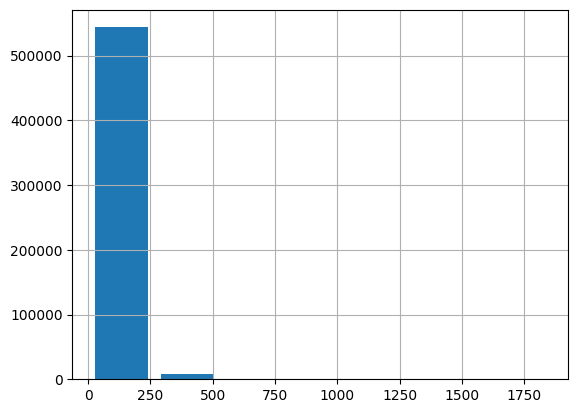

In [ ]:
a = [str(x) for x in x_train_list]
lens = [len(i) for i in a]
pd.Series(lens).hist(bins=7, rwidth=0.8)

In [ ]:
# tìm từ có len gần bằng 95% char_lens
output_len = int(np.percentile(lens, 95))
output_len

171

In [ ]:
words = []

for word in df['preprocess']:
    words.append(word)
# giới hạn tối đa của câu
max_tokens = len(set(words))
max_tokens

615656

In [ ]:
# tạo số cột tương ứng với số lượng thuộc tính của y => 2 cột y được tạo
y_train_one_hot = tf.one_hot(y_train.to_numpy(), depth=len(set(y)))
y_val_one_hot = tf.one_hot(y_val.to_numpy(), depth=len(set(y)))
y_test_one_hot = tf.one_hot(y_test.to_numpy(), depth=len(set(y)))

y_train_one_hot

<tf.Tensor: shape=(551503, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)>

#Khởi tạo TextVectorization

In [ ]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    standardize="lower",
                                    split="whitespace",
                                    output_sequence_length=output_len)

In [ ]:
text_vectorizer.adapt(x_train_list)

In [ ]:
vocab = text_vectorizer.get_vocabulary()
len(vocab)

59601

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_list, y_train_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((x_val_list, y_val_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_list, y_test_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [ ]:
token_embedding = Embedding(input_dim = len(vocab),
                           output_dim = output_len,
                           mask_zero=True,
                           name="token_embedding")

#TextVectorization cho ML

In [ ]:
x_train_list_ml = x_train.tolist()
x_test_list_ml = x_temp.tolist()

In [ ]:
x_train_vectors = text_vectorizer(x_train_list_ml).numpy()
x_test_vectors = text_vectorizer(x_test_list_ml).numpy()

#Bi-LSTM TextVectorization binary accurracy

In [ ]:
activation_function = 'tanh'

inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embedding(text_vectors)

x = Bidirectional(LSTM(256, return_sequences=True))(token_embeddings)
x = GlobalAveragePooling1D()(x)
x = Dense(units=500, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=200, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=100, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=50, activation=activation_function)(x)
outputs = Dense(len(set(df['target'])), activation="sigmoid")(x)

bilstm_textvector = tf.keras.Model(inputs, outputs)


bilstm_textvector.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

bilstm_textvector.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 171)               0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 171, 171)          10191771  
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 171, 512)          876544    
 al)                                                             
                                                                 
 global_average_pooling1d (  (None, 512)               0         
 GlobalAveragePooling1D)                                     

In [ ]:
history = bilstm_textvector.fit(train_dataset,
                           epochs=100,
                           validation_data= valid_dataset,
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

bilstm_textvector.evaluate(valid_dataset)

Epoch 1/100
17235/17235 [==============================] - 402s 22ms/step - loss: 0.3460 - accuracy: 0.8580 - val_loss: 0.3246 - val_accuracy: 0.8684
Epoch 2/100
17235/17235 [==============================] - 340s 20ms/step - loss: 0.3084 - accuracy: 0.8776 - val_loss: 0.3264 - val_accuracy: 0.8660
Epoch 3/100
17235/17235 [==============================] - 338s 20ms/step - loss: 0.2925 - accuracy: 0.8856 - val_loss: 0.3307 - val_accuracy: 0.8659
Epoch 4/100
17235/17235 [==============================] - 340s 20ms/step - loss: 0.2830 - accuracy: 0.8913 - val_loss: 0.3355 - val_accuracy: 0.8647
Epoch 5/100
17235/17235 [==============================] - 368s 21ms/step - loss: 0.2763 - accuracy: 0.8952 - val_loss: 0.3384 - val_accuracy: 0.8616
Epoch 6/100
2155/2155 [==============================] - 14s 7ms/step - loss: 0.3395 - accuracy: 0.8663


[0.33948883414268494, 0.8663291931152344]

In [ ]:
bilstm_textvector_pred_probs = bilstm_textvector.predict(test_dataset)

bilstm_textvector_preds = tf.argmax(bilstm_textvector_pred_probs, axis=1)

bilstm_textvector_results = calculate_results(y_true=y_test,
                                    y_pred=bilstm_textvector_preds)
bilstm_textvector_results

2155/2155 [==============================] - 15s 6ms/step


{'accuracy': 0.8652702428268879,
 'precision': 0.8650752298244881,
 'recall': 0.8652702428268879,
 'f1': 0.8648655759196746}

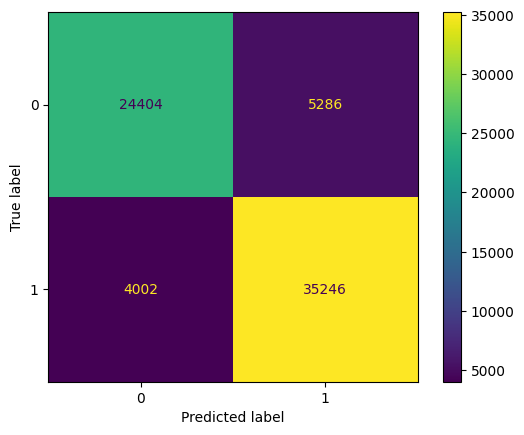

In [ ]:
confusion_matrix_bilstm_textvector = m.ConfusionMatrixDisplay.from_predictions(y_test, bilstm_textvector_preds)
confusion_matrix_bilstm_textvector

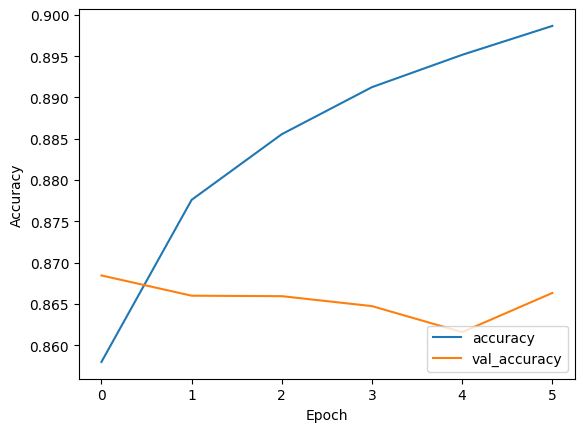

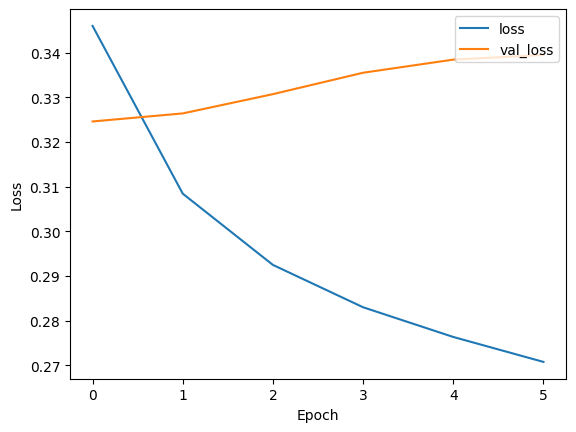

In [ ]:
# Biểu đồ độ chính xác
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Biểu đồ hàm mất mát
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


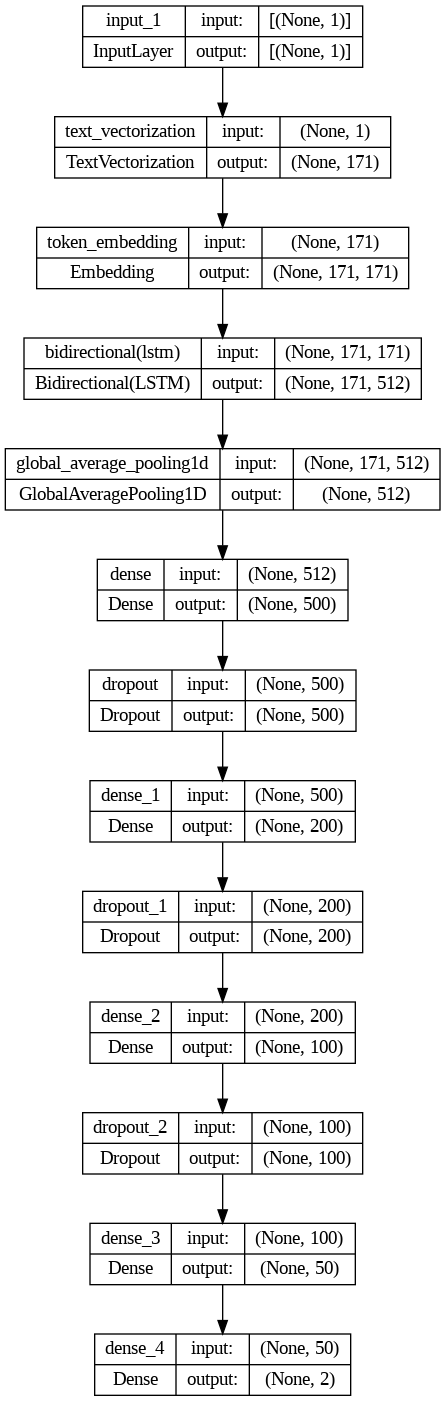

In [ ]:
from keras.utils import plot_model

plot_model(bilstm_textvector, to_file='bilstm_textvector.png', show_shapes=True, show_layer_names=True)


In [ ]:
joblib.dump(bilstm_textvector, '/content/gdrive/MyDrive/Tieu_luan/bilstm_textvector.pkl')

['/content/gdrive/MyDrive/Tieu_luan/bilstm_textvector.pkl']

#Naive Bayes TextVectorization

In [ ]:
bayes_textvector_none = MultinomialNB(fit_prior = True, alpha = 0.01)

bayes_textvector_none.fit(x_train_vectors, y_train)

MultinomialNB(alpha=0.01)

In [ ]:
bayes_textvector_none_predict = bayes_textvector_none.predict(x_test_vectors)

bayes_textvector_none_results = calculate_results(y_true=y_temp,
                                     y_pred=bayes_textvector_none_predict)
bayes_textvector_none_results

{'accuracy': 0.6287751312773797,
 'precision': 0.6277434954246709,
 'recall': 0.6287751312773797,
 'f1': 0.6017449880653339}

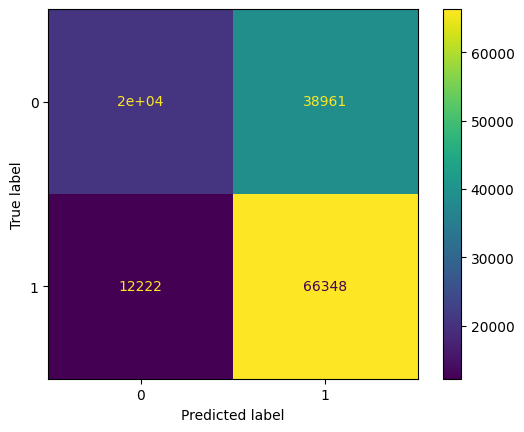

In [ ]:
confusion_matrix_bayes_doc2vec = m.ConfusionMatrixDisplay.from_predictions(y_temp, bayes_textvector_none_predict)
confusion_matrix_bayes_doc2vec

#Decision Tree TextVectorization

In [ ]:
dt_textvector_none = DecisionTreeClassifier(min_samples_split=10,
                                           min_samples_leaf=1,
                                           max_depth=20,
                                           criterion = 'entropy')

dt_textvector_none.fit(x_train_vectors, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=10)

In [ ]:
dt_word2vec_none_predict = dt_textvector_none.predict(x_test_vectors)

dt_textvector_none_results = calculate_results(y_true=y_temp,
                                     y_pred=dt_word2vec_none_predict)
dt_textvector_none_results

{'accuracy': 0.7157663407699673,
 'precision': 0.7158488562551566,
 'recall': 0.7157663407699673,
 'f1': 0.715806868479162}

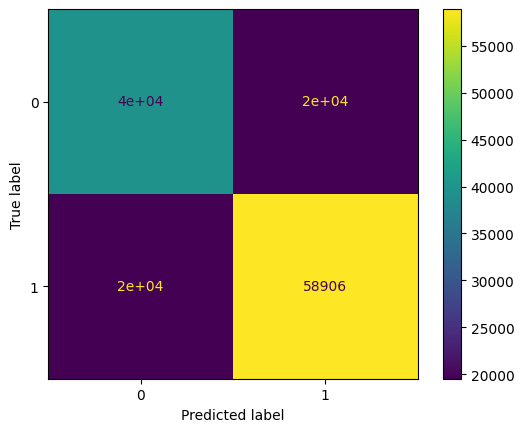

In [ ]:
confusion_matrix_dt_doc2vec = m.ConfusionMatrixDisplay.from_predictions(y_temp, dt_word2vec_none_predict)
confusion_matrix_dt_doc2vec

#Word2Vec

In [ ]:
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size=200, window=5, min_count=1, workers=4):
        self.size = size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None
        self.vector_size = None

    def fit(self, X, y=None):
        sentences = [text.split() for text in X]
        self.model = Word2Vec(sentences, vector_size=self.size, window=self.window, min_count=self.min_count, workers=self.workers)
        self.vector_size = self.model.vector_size
        return self

    def transform(self, X, y=None):
        sentences = [text.split() for text in X]
        X_transformed = np.array([np.mean([self.model.wv[word] for word in sentence if word in self.model.wv]
                                          or [np.zeros(self.vector_size)], axis=0) for sentence in sentences])
        return X_transformed
class PositiveScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X, y=None):
        return self.scaler.transform(X)

In [ ]:
word2vec = Word2VecTransformer()
word2vec.fit(x_train)

Word2VecTransformer()

In [ ]:
#DL
x_train_word2vec = word2vec.transform(x_train_list)
x_val_word2vec = word2vec.transform(x_val_list)
x_test_word2vec = word2vec.transform(x_test_list)

#ML
x_train_ml_word2vec = word2vec.transform(x_train_list_ml)
x_test_ml_word2vec = word2vec.transform(x_test_list_ml)

#Bi - LSTM Word2Vec

In [ ]:
activation_function = 'tanh'
input_shape = x_train_word2vec.shape[1]

inputs = Input(shape=(input_shape,))
x = tf.expand_dims(inputs, axis=-1)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = GlobalAveragePooling1D()(x)
x = Dense(units=500, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=200, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=100, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=50, activation=activation_function)(x)
outputs = Dense(len(set(df['target'])), activation="softmax")(x)

bilstm_word2vec = tf.keras.Model(inputs, outputs)

bilstm_word2vec.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])
bilstm_word2vec.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 tf.expand_dims (TFOpLambda  (None, 200, 1)            0         
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 200, 512)          528384    
 al)                                                             
                                                                 
 global_average_pooling1d (  (None, 512)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 500)               256500    
                                                             

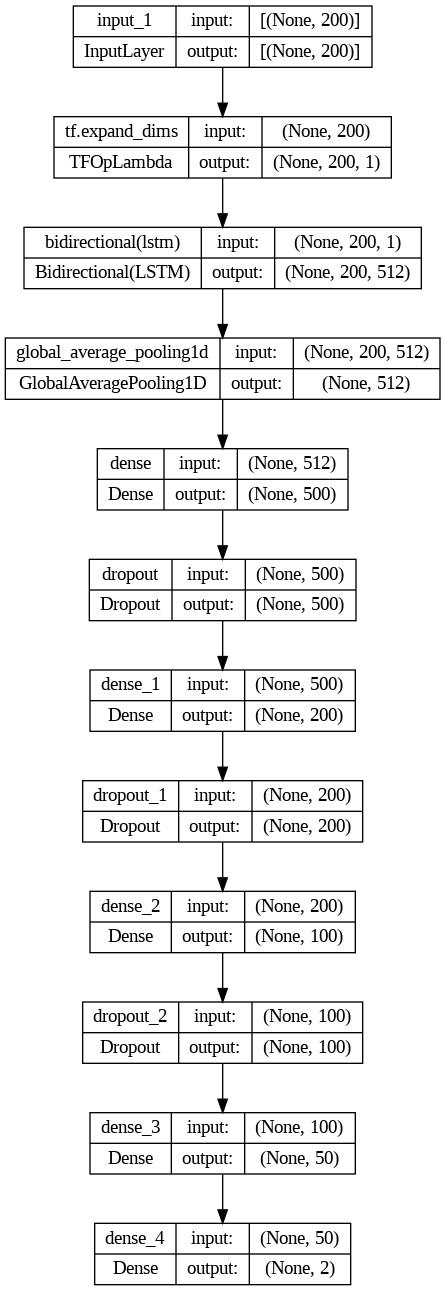

In [ ]:
from keras.utils import plot_model

plot_model(bilstm_word2vec, to_file='bilstm_word2vec.png', show_shapes=True, show_layer_names=True)


In [ ]:
history = bilstm_word2vec.fit(x_train_word2vec, y_train_one_hot,
                           epochs=100,
                           batch_size=32,
                           validation_data= (x_val_word2vec, y_val_one_hot),
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])
loss, accuracy = bilstm_word2vec.evaluate(x_val_word2vec, y_val_one_hot)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

Epoch 1/100
17235/17235 [==============================] - 419s 24ms/step - loss: 0.5509 - accuracy: 0.7159 - val_loss: 0.4895 - val_accuracy: 0.7702
Epoch 2/100
17235/17235 [==============================] - 407s 24ms/step - loss: 0.4834 - accuracy: 0.7743 - val_loss: 0.4497 - val_accuracy: 0.7970
Epoch 3/100
17235/17235 [==============================] - 406s 24ms/step - loss: 0.4579 - accuracy: 0.7916 - val_loss: 0.4444 - val_accuracy: 0.7954
Epoch 4/100
17235/17235 [==============================] - 426s 25ms/step - loss: 0.4517 - accuracy: 0.7958 - val_loss: 0.4391 - val_accuracy: 0.8036
Epoch 5/100
17235/17235 [==============================] - 409s 24ms/step - loss: 0.4382 - accuracy: 0.8031 - val_loss: 0.4176 - val_accuracy: 0.8149
Epoch 6/100
17235/17235 [==============================] - 428s 25ms/step - loss: 0.4546 - accuracy: 0.7939 - val_loss: 0.4460 - val_accuracy: 0.8020
Epoch 7/100
17235/17235 [==============================] - 403s 23ms/step - loss: 0.4444 - accuracy:

In [ ]:
bilstm_word2vec_pred_probs = bilstm_word2vec.predict(x_test_word2vec)

bilstm_word2vec_preds = tf.argmax(bilstm_word2vec_pred_probs, axis=1)

bilstm_word2vec_results = calculate_results(y_true=y_test,
                                    y_pred=bilstm_word2vec_preds)
bilstm_word2vec_results

2155/2155 [==============================] - 20s 9ms/step


{'accuracy': 0.8137456845281267,
 'precision': 0.8147481938231512,
 'recall': 0.8137456845281267,
 'f1': 0.8140809268458765}

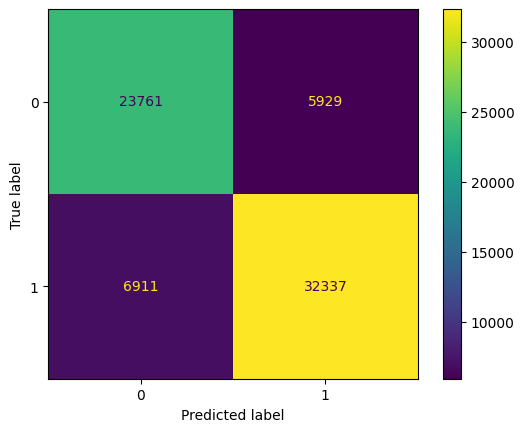

In [ ]:
confusion_matrix_bilstm_word2vec = m.ConfusionMatrixDisplay.from_predictions(y_test, bilstm_word2vec_preds)
confusion_matrix_bilstm_word2vec

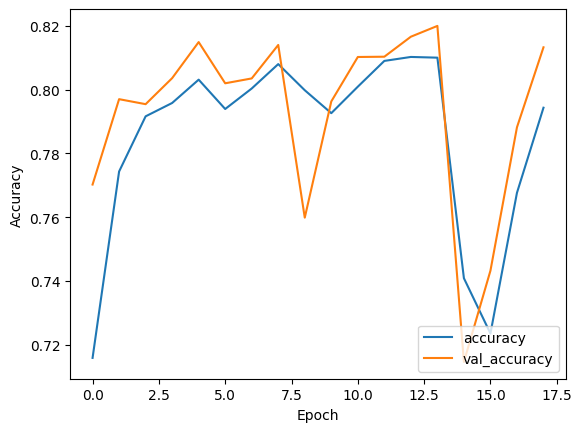

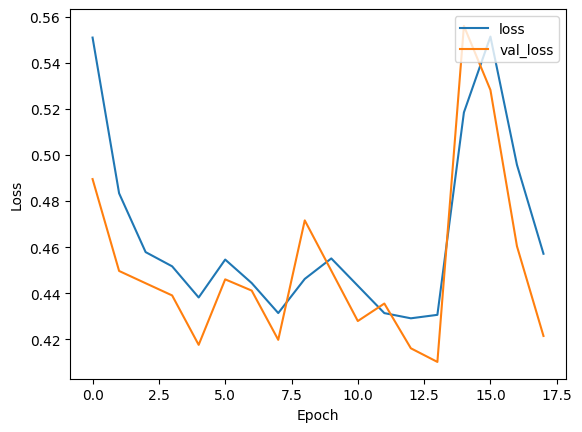

In [ ]:
# Biểu đồ độ chính xác
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Biểu đồ hàm mất mát
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [ ]:
joblib.dump(bilstm_word2vec, '/content/gdrive/MyDrive/Tieu_luan/model_BiLSTM_word2vec.pkl')

['/content/gdrive/MyDrive/Tieu_luan/model_BiLSTM_word2vec.pkl']

#Naive Bayes Word2Vec

In [ ]:
bayes_word2vec = Pipeline([
    ("scaler", PositiveScaler()),
    ("clf", MultinomialNB(fit_prior = True,
                          alpha = 0.01))
])

bayes_word2vec.fit(x_train_ml_word2vec, y_train)

Pipeline(steps=[('scaler', PositiveScaler()),
                ('clf', MultinomialNB(alpha=0.01))])

In [ ]:
bayes_word2vec_predict = bayes_word2vec.predict(x_test_ml_word2vec)

bayes_word2vec_results = calculate_results(y_true=y_temp,
                                     y_pred=bayes_word2vec_predict)
bayes_word2vec_results

{'accuracy': 0.667715918651542,
 'precision': 0.728167410230779,
 'recall': 0.667715918651542,
 'f1': 0.6171900509663868}

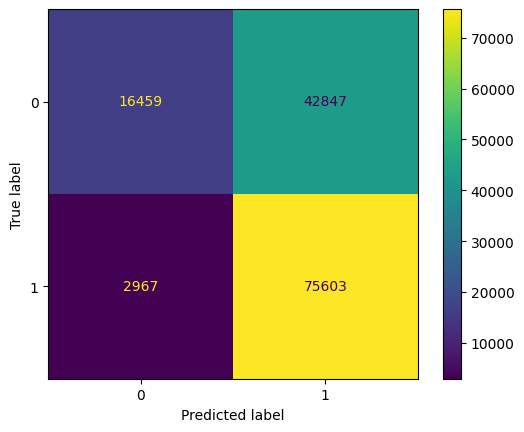

In [ ]:
confusion_matrix_bayes_doc2vec = m.ConfusionMatrixDisplay.from_predictions(y_temp, bayes_word2vec_predict)
confusion_matrix_bayes_doc2vec

#Decision Tree Word2Vec

In [ ]:
dt_word2vec = DecisionTreeClassifier(min_samples_split=10,
                                           min_samples_leaf=1,
                                           max_depth=20,
                                           criterion = 'entropy')

dt_word2vec.fit(x_train_ml_word2vec, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=10)

In [ ]:
dt_word2vec_predict = dt_word2vec.predict(x_test_ml_word2vec)

dt_word2vec_results = calculate_results(y_true=y_temp,
                                     y_pred=dt_word2vec_predict)
dt_word2vec_results

{'accuracy': 0.7767559256143202,
 'precision': 0.7769537646158626,
 'recall': 0.7767559256143202,
 'f1': 0.7768479943228668}

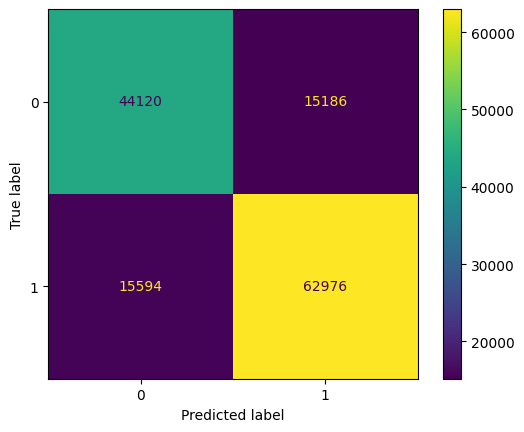

In [ ]:
confusion_matrix_dt_doc2vec = m.ConfusionMatrixDisplay.from_predictions(y_temp, dt_word2vec_predict)
confusion_matrix_dt_doc2vec

#Tổng hợp

In [4]:
results = {
    "TextVectorization Bi - LSTM": bilstm_textvector_results,
    "TextVectorization Naive Bayes": bayes_textvector_results,
    "TextVectorization Decision Tree": dt_textvector_results,
    "Word2Vec Bi - LSTM": bilstm_word2vec_results,
    "Word2Vec Naive Bayes": bayes_word2vec_results,
    "Word2Vec Decision Tree": dt_word2vec_results
}

results_df = pd.DataFrame(results).T

results_df_rounded = results_df.round(4)

print(results_df_rounded)

                                 accuracy  precision  recall  f1-score
TextVectorization Bi - LSTM        0.8653     0.8651  0.8653    0.8649
TextVectorization Naive Bayes      0.6288     0.6277  0.6288    0.6017
TextVectorization Decision Tree    0.7158     0.7158  0.7158    0.7158
Word2Vec Bi - LSTM                 0.8137     0.8147  0.8137    0.8140
Word2Vec Naive Bayes               0.6677     0.7282  0.6677    0.6172
Word2Vec Decision Tree             0.7768     0.7770  0.7768    0.7768


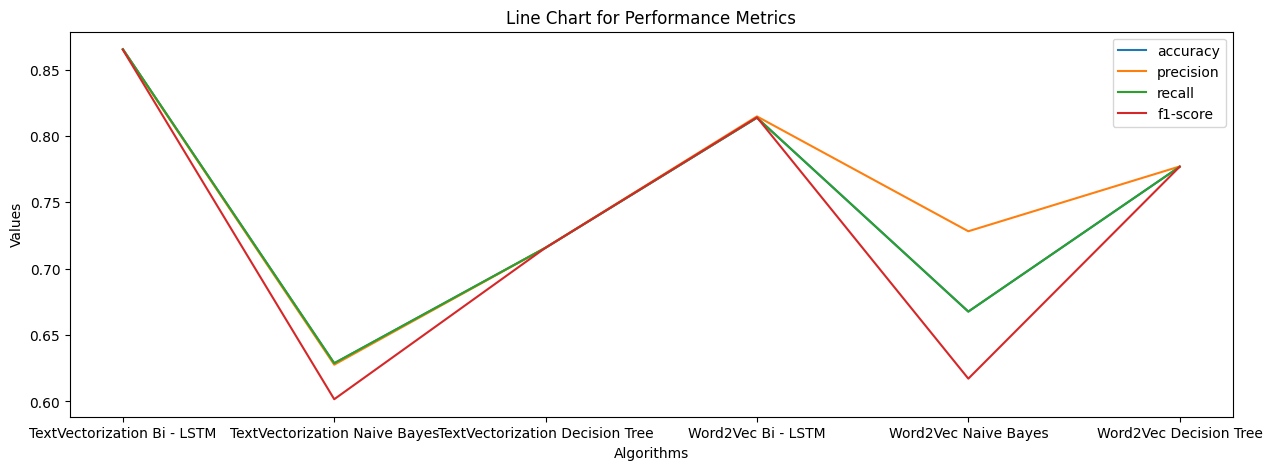

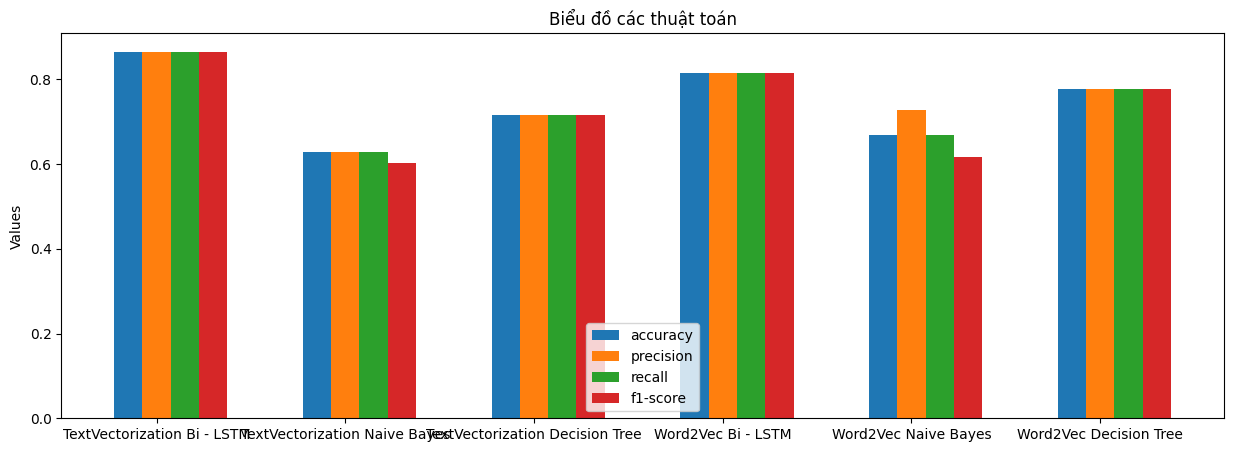

In [5]:
import matplotlib.pyplot as plt

metrics = {
     'TextVectorization Bi - LSTM': {'accuracy': 0.8653, 'precision': 0.8651 , 'recall': 0.8653, 'f1-score': 0.8649},
    'TextVectorization Naive Bayes': {'accuracy': 0.6288, 'precision': 0.6277, 'recall': 0.6288, 'f1-score': 0.6017},
    'TextVectorization Decision Tree': {'accuracy': 0.7158, 'precision': 0.7158, 'recall': 0.7158, 'f1-score': 0.7158},
    'Word2Vec Bi - LSTM': {'accuracy': 0.8137, 'precision': 0.8147, 'recall': 0.8137, 'f1-score': 0.814},
    'Word2Vec Naive Bayes': {'accuracy': 0.6677, 'precision': 0.7282, 'recall': 0.6677, 'f1-score': 0.6172},
    'Word2Vec Decision Tree': {'accuracy': 0.7768, 'precision': 0.777, 'recall': 0.7768, 'f1-score': 0.7768}
}

# Vẽ biểu đồ đường cho từng chỉ số
plt.figure(figsize=(15, 5))
for metric in ['accuracy', 'precision', 'recall', 'f1-score']:
    plt.plot(metrics.keys(), [values[metric] for values in metrics.values()], label=metric)
plt.title('Line Chart for Performance Metrics')
plt.xlabel('Algorithms')
plt.ylabel('Values')
plt.legend()
plt.show()

# Vẽ biểu đồ cột cho từng chỉ số
fig, ax = plt.subplots(figsize=(15, 5))
width = 0.15
algorithms = list(metrics.keys())
for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1-score']):
    ax.bar([x + i*width for x in range(len(algorithms))], [values[metric] for values in metrics.values()], width=width, label=metric)
ax.set_title('Biểu đồ các thuật toán')
ax.set_xticks([x + width for x in range(len(algorithms))])
ax.set_xticklabels(algorithms)
ax.set_ylabel('Values')
ax.legend()
plt.show()


#Naive Bayes TextVectorization RandomizedSearchCV

In [ ]:
bayes_textvector = MultinomialNB()
param_dist = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'fit_prior': [True, False]
}

# Khởi tạo RandomizedSearchCV
random_search_bayes_textvector = RandomizedSearchCV(estimator=bayes_textvector, param_distributions=param_dist,
                                                    n_iter=10, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)

In [ ]:
random_search_bayes_textvector.fit(x_train_vectors, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
                   param_distributions={'alpha': [0.01, 0.1, 1, 10, 100],
                                        'fit_prior': [True, False]},
                   random_state=42, scoring='accuracy')

In [ ]:
print("Best parameters: ", random_search_bayes_textvector.best_params_)
print("Best accuracy: ", random_search_bayes_textvector.best_score_)

Best parameters:  {'fit_prior': True, 'alpha': 0.01}
Best accuracy:  0.6304263050477642


In [ ]:
print("All Results:")
for i in range(len(random_search_bayes_textvector.cv_results_['params'])):
    params = random_search_bayes_textvector.cv_results_['params'][i]
    mean_score = random_search_bayes_textvector.cv_results_['mean_test_score'][i]
    mean_fit_time = random_search_bayes_textvector.cv_results_['mean_fit_time'][i]
    std_fit_time = random_search_bayes_textvector.cv_results_['std_fit_time'][i]
    print(f"{params} --> Accuracy: {mean_score:.4f}, ")
    print(f"Fit Time: {mean_fit_time:.4f} ± {std_fit_time:.4f} seconds")

All Results:
{'fit_prior': True, 'alpha': 0.01} --> Accuracy: 0.6304, 
Fit Time: 3.6940 ± 0.0994 seconds
{'fit_prior': False, 'alpha': 0.01} --> Accuracy: 0.6304, 
Fit Time: 4.5453 ± 0.8238 seconds
{'fit_prior': True, 'alpha': 0.1} --> Accuracy: 0.6304, 
Fit Time: 4.3525 ± 0.4905 seconds
{'fit_prior': False, 'alpha': 0.1} --> Accuracy: 0.6304, 
Fit Time: 4.3614 ± 0.2844 seconds
{'fit_prior': True, 'alpha': 1} --> Accuracy: 0.6304, 
Fit Time: 3.7516 ± 0.2373 seconds
{'fit_prior': False, 'alpha': 1} --> Accuracy: 0.6304, 
Fit Time: 4.1721 ± 0.5077 seconds
{'fit_prior': True, 'alpha': 10} --> Accuracy: 0.6304, 
Fit Time: 3.9176 ± 0.3981 seconds
{'fit_prior': False, 'alpha': 10} --> Accuracy: 0.6304, 
Fit Time: 3.8461 ± 0.2773 seconds
{'fit_prior': True, 'alpha': 100} --> Accuracy: 0.6304, 
Fit Time: 3.9207 ± 0.3105 seconds
{'fit_prior': False, 'alpha': 100} --> Accuracy: 0.6304, 
Fit Time: 4.1750 ± 0.4172 seconds


In [ ]:
bayes_textvector_predict = random_search_bayes_textvector.predict(x_test_vectors)

bayes_textvector_results = calculate_results(y_true=y_temp,
                                     y_pred=bayes_textvector_predict)
bayes_textvector_results

{'accuracy': 0.6287751312773797,
 'precision': 0.6277434954246709,
 'recall': 0.6287751312773797,
 'f1': 0.6017449880653339}

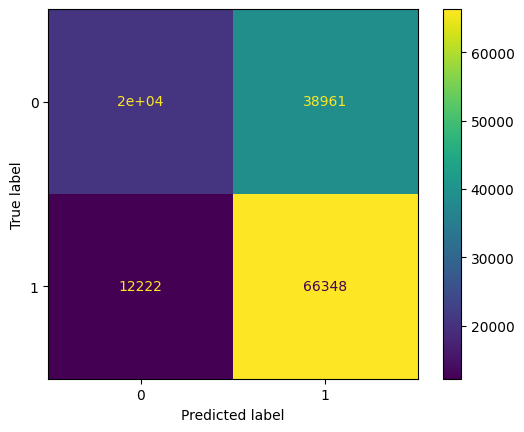

In [ ]:
confusion_matrix_bayes_textvector = m.ConfusionMatrixDisplay.from_predictions(y_temp, bayes_textvector_predict)
confusion_matrix_bayes_textvector

#Decision Tree TextVectorization RandomizedSearchCV

In [ ]:
dt_textvector = DecisionTreeClassifier()

param_grid = {
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

random_search_dt_textvector = RandomizedSearchCV(estimator=dt_textvector, param_distributions=param_grid,
                                      n_iter=50, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)

In [ ]:
random_search_dt_textvector.fit(x_train_vectors, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='accuracy')

In [ ]:
print("Best parameters: ", random_search_dt_textvector.best_params_)
print("Best accuracy: ", random_search_dt_textvector.best_score_)

Best parameters:  {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'entropy'}
Best accuracy:  0.7198328833037542


In [ ]:
print("All Results:")
for i in range(len(random_search_dt_textvector.cv_results_['params'])):
    params = random_search_dt_textvector.cv_results_['params'][i]
    mean_score = random_search_dt_textvector.cv_results_['mean_test_score'][i]
    mean_fit_time = random_search_dt_textvector.cv_results_['mean_fit_time'][i]
    std_fit_time = random_search_dt_textvector.cv_results_['std_fit_time'][i]
    print(f"{params} --> Accuracy: {mean_score:.4f}, ")
    print(f"Fit Time: {mean_fit_time:.4f} ± {std_fit_time:.4f} seconds")

All Results:
{'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy'} --> Accuracy: 0.7094, 
Fit Time: 23.6366 ± 0.4203 seconds
{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'gini'} --> Accuracy: 0.7173, 
Fit Time: 17.9538 ± 0.6883 seconds
{'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini'} --> Accuracy: 0.7019, 
Fit Time: 12.4365 ± 1.4877 seconds
{'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 40, 'criterion': 'entropy'} --> Accuracy: 0.7031, 
Fit Time: 25.4745 ± 1.6135 seconds
{'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'entropy'} --> Accuracy: 0.7007, 
Fit Time: 12.3593 ± 1.0095 seconds
{'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'criterion': 'entropy'} --> Accuracy: 0.7188, 
Fit Time: 19.7402 ± 0.5556 seconds
{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 40, 'criterion': 'gini'} --> Accuracy: 0.6962, 

In [ ]:
dt_textvector_predict = random_search_dt_textvector.predict(x_test_vectors)

dt_textvector_results = calculate_results(y_true=y_temp,
                                     y_pred=dt_textvector_predict)
dt_textvector_results

{'accuracy': 0.7157953523455859,
 'precision': 0.7159031233414541,
 'recall': 0.7157953523455859,
 'f1': 0.7158480000364424}

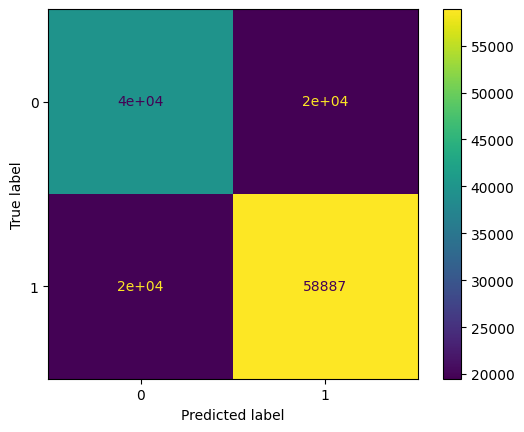

In [ ]:
confusion_matrix_dt_textvector = m.ConfusionMatrixDisplay.from_predictions(y_temp, dt_textvector_predict)
confusion_matrix_dt_textvector

#Bi-LSTM TextVectorization category

In [ ]:
activation_function = 'tanh'

inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embedding(text_vectors)

x = Bidirectional(LSTM(256, return_sequences=True))(token_embeddings)
x = GlobalAveragePooling1D()(x)
x = Dense(units=500, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=200, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=100, activation=activation_function)(x)
x = Dropout(0.5)(x)
x = Dense(units=50, activation=activation_function)(x)
outputs = Dense(len(set(df['target'])), activation="softmax")(x)

bilstm_textvector = tf.keras.Model(inputs, outputs)


bilstm_textvector.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

bilstm_textvector.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 171)               0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 171, 171)          10191771  
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 171, 512)          876544    
 al)                                                             
                                                                 
 global_average_pooling1d (  (None, 512)               0         
 GlobalAveragePooling1D)                                     

In [ ]:
history = bilstm_textvector.fit(train_dataset,
                           epochs=100,
                           validation_data= valid_dataset,
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

bilstm_textvector.evaluate(valid_dataset)

Epoch 1/100
17235/17235 [==============================] - 362s 21ms/step - loss: 0.3143 - accuracy: 0.8743 - val_loss: 0.3267 - val_accuracy: 0.8704
Epoch 2/100
17235/17235 [==============================] - 357s 21ms/step - loss: 0.2974 - accuracy: 0.8842 - val_loss: 0.3250 - val_accuracy: 0.8694
Epoch 3/100
17235/17235 [==============================] - 339s 20ms/step - loss: 0.2860 - accuracy: 0.8901 - val_loss: 0.3264 - val_accuracy: 0.8685
Epoch 4/100
17235/17235 [==============================] - 337s 20ms/step - loss: 0.2787 - accuracy: 0.8942 - val_loss: 0.3352 - val_accuracy: 0.8665
Epoch 5/100
17235/17235 [==============================] - 335s 19ms/step - loss: 0.2725 - accuracy: 0.8973 - val_loss: 0.3334 - val_accuracy: 0.8676
Epoch 6/100
17235/17235 [==============================] - 347s 20ms/step - loss: 0.2692 - accuracy: 0.9000 - val_loss: 0.3493 - val_accuracy: 0.8657
Epoch 7/100
17235/17235 [==============================] - 341s 20ms/step - loss: 0.2663 - accuracy:

[0.3655354976654053, 0.8621805310249329]

In [ ]:
bilstm_textvector_pred_probs = bilstm_textvector.predict(test_dataset)

bilstm_textvector_preds = tf.argmax(bilstm_textvector_pred_probs, axis=1)

bilstm_textvector_results = calculate_results(y_true=y_test,
                                    y_pred=bilstm_textvector_preds)
bilstm_textvector_results

2155/2155 [==============================] - 15s 6ms/step


{'accuracy': 0.8607154254547564,
 'precision': 0.8604512518096036,
 'recall': 0.8607154254547564,
 'f1': 0.8604480617311455}

In [ ]:
bilstm_textvector_pred_probs = bilstm_textvector.predict(test_dataset)

bilstm_textvector_preds = tf.argmax(bilstm_textvector_pred_probs, axis=1)

bilstm_textvector_results = calculate_results(y_true=y_test,
                                    y_pred=bilstm_textvector_preds)
bilstm_textvector_results

2155/2155 [==============================] - 15s 6ms/step


{'accuracy': 0.8652702428268879,
 'precision': 0.8650752298244881,
 'recall': 0.8652702428268879,
 'f1': 0.8648655759196746}

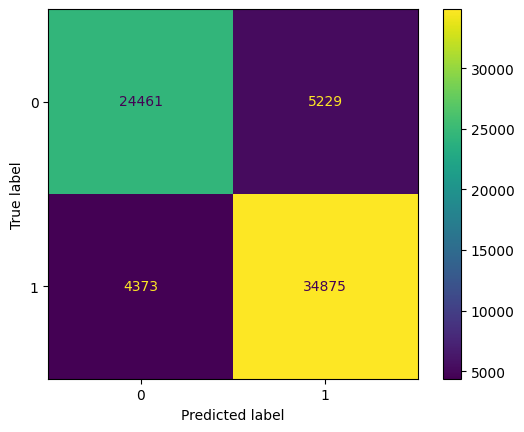

In [ ]:
confusion_matrix_bilstm_textvector = m.ConfusionMatrixDisplay.from_predictions(y_test, bilstm_textvector_preds)
confusion_matrix_bilstm_textvector

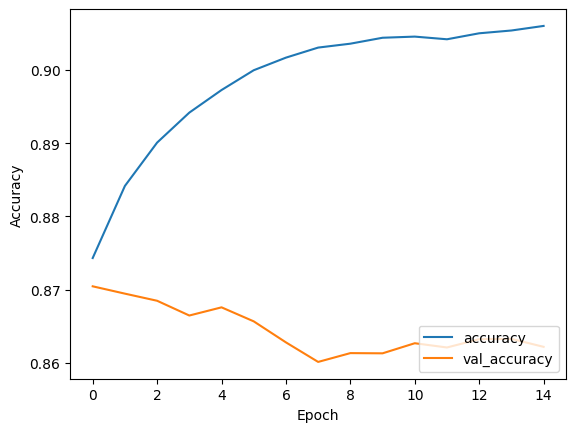

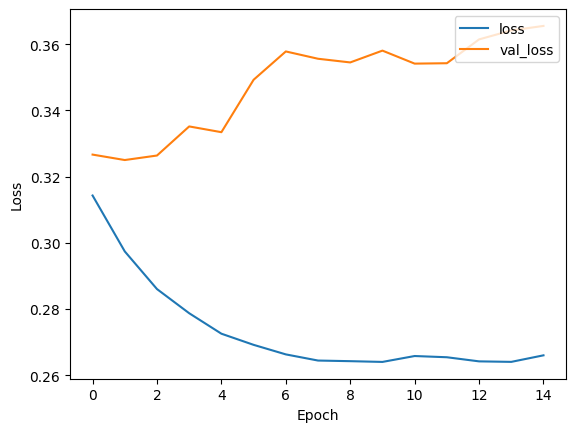

In [ ]:
# Biểu đồ độ chính xác
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Biểu đồ hàm mất mát
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


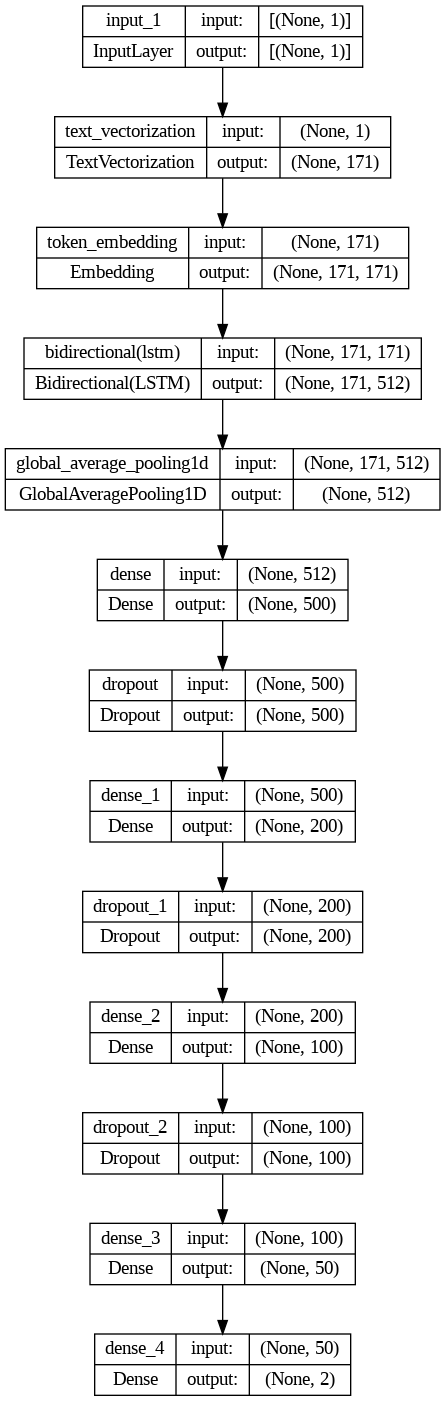

In [ ]:
from keras.utils import plot_model

plot_model(bilstm_textvector, to_file='bilstm_textvector.png', show_shapes=True, show_layer_names=True)


In [ ]:
joblib.dump(bilstm_textvector, '/content/gdrive/MyDrive/Tieu_luan/bilstm_textvector.pkl')

['/content/gdrive/MyDrive/Tieu_luan/bilstm_textvector.pkl']